In [1]:
import gym
import numpy as np

In [2]:
env = gym.make("FrozenLake-v1")
env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


In [23]:
"""
We start it by a Expected-SARSA agent with no modification on the reward function
"""
from collections import defaultdict
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

class ESarsa_no_penalty():
    def __init__(self,
                env,gamma,epsilon,alpha):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.q = defaultdict(lambda : np.zeros(env.action_space.n))
    
    def choose_action(self, state):
        epsilon = self.epsilon
        if np.random.random() < epsilon:
            return env.action_space.sample()
        else:
            return np.argmax(self.q[state])
        
    def action_possibility(self, state):
        epsilon = self.epsilon
        P = []
        actions = self.q[state]
        n = env.action_space.n
        for i in range(0,n):
            if i == np.argmax(actions):
                P.append((epsilon/n) + 1 - epsilon)
            else:
                P.append(epsilon/n)
        return P
            
    def update_q(self, state, action, next_state, next_action, reward):
        P = self.action_possibility(next_state)        
        V = P * self.q[next_state]
        self.q[state][action] += self.alpha * (reward + self.gamma*sum(V) - self.q[state][action])
        
    
    def run_step(self, state, action):
        next_state, reward, done, _ = self.env.step(action)
        next_action = self.choose_action(next_state)
        self.update_q(state,action,next_state,next_action,reward)
        return next_state, next_action,reward,done
        
    def run_episode(self):
        epsilon = self.epsilon
        alpha = self.alpha
        episode_return = 0
        
        state = self.env.reset()
        action = self.choose_action(state)
        
        while True:
            state, action, reward,done = self.run_step(state,action)
            episode_return += reward
            if done:
                break
        return episode_return
    
    def learn_task(self, n):
        returns = []
        for i in tqdm(range(n)):
            episode_return = self.run_episode()
            returns.append(episode_return)
            if episode_return > 0:
                self.epsilon -= 0.01
        return returns

    

In [29]:
env = gym.make("FrozenLake-v1")
env.reset()

no_penalty_agent = ESarsa_no_penalty(env, gamma = 0.9, epsilon = 0.1,
           alpha = 0.1)
no_penalty_results = no_penalty_agent.learn_task(10000)

100%|███████████████████████████████████| 10000/10000 [00:03<00:00, 3331.95it/s]


In [31]:
"""The result is just too bad"""
print("The average reward in Expected SARSA with no penaltyagent epsilon = 0.01: \t", np.average(no_penalty_results))

The average reward in Expected SARSA with no penaltyagent epsilon = 0.01: 	 0.0144


In [3]:
"""
We start it by a SARSA agent

In the reward function, for anytime the agent fall into the hole,
I give -0.5 penalty when updating to the Q-table so the agent will know hole is not expected

I started with give -10 for each hole, but it will never coverage because it make the goal reward too small

The experiments to current reward function is not shown, this is a working solution
"""


class Sarsa():
    def __init__(self,
                env,gamma,epsilon,alpha):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.q = defaultdict(lambda : np.zeros(env.action_space.n))
    
    def choose_action(self, state):
        epsilon = self.epsilon
        if np.random.random() < epsilon:
            return env.action_space.sample()
        else:
            return np.argmax(self.q[state])
        
    def greedy_action(self, state):
        return np.argmax(self.q[state])
        
    def update_q(self, state, action, next_state, next_action, reward):
        self.q[state][action] += self.alpha * (reward + self.gamma*self.q[next_state][next_action] - self.q[state][action]) 
    
    def run_step(self, state, action):
        next_state, reward, done, _ = self.env.step(action)
        next_action = self.choose_action(next_state)
        if reward == 0 and done:
            reward = -0.5    
        self.update_q(state,action,next_state,next_action,reward)
        return next_state, next_action,reward,done
        
    def run_episode(self):
        epsilon = self.epsilon
        alpha = self.alpha
        episode_return = 0
        
        state = self.env.reset()
        action = self.choose_action(state)
        
        while True:
            state, action, reward,done = self.run_step(state,action)
            episode_return += reward
            if done: 
                episode_return = max(0, episode_return)
                
                break
        return episode_return
    
    def learn_task(self, n):
        returns = []
        for i in tqdm(range(n)):
            episode_return = self.run_episode()
            returns.append(episode_return)
        print(self.q)
        return returns

In [4]:
"""
We want to see how does epsilon affect the performance
"""

env = gym.make("FrozenLake-v1")
env.reset()
env.render()    
agent1 = Sarsa(env, gamma = 0.9, epsilon = 0.01,
           alpha = 0.1)

agent2 = Sarsa(env, gamma = 0.9, epsilon = 0.05,
           alpha = 0.1)

agent3 = Sarsa(env, gamma = 0.9, epsilon = 0.1,
           alpha = 0.1)

agent4 = Sarsa(env, gamma = 0.9, epsilon = 0.3,
           alpha = 0.1)

s1 = agent1.learn_task(10000)
s2 = agent2.learn_task(10000)
s3 = agent3.learn_task(10000)
s4 = agent4.learn_task(10000)


SFFF
FHFH
FFFH
HFFG


100%|███████████████████████████████████| 10000/10000 [00:08<00:00, 1215.84it/s]


defaultdict(<function Sarsa.__init__.<locals>.<lambda> at 0x7fe2171f89d0>, {0: array([ 0.04366839, -0.02992102, -0.025904  , -0.03104274]), 4: array([ 0.07617608, -0.19145513, -0.03435882, -0.07264802]), 8: array([-0.19190031, -0.07646932, -0.05254576,  0.1238771 ]), 12: array([0., 0., 0., 0.]), 9: array([-0.12317049,  0.17169982, -0.00749491, -0.06977114]), 13: array([ 0.00267231,  0.05533553,  0.27291877, -0.03404425]), 5: array([0., 0., 0., 0.]), 10: array([ 0.1461381 , -0.08211702, -0.06050448, -0.11663242]), 6: array([-0.14384596, -0.36172194, -0.35524044, -0.30546185]), 2: array([-0.08488152, -0.0805097 , -0.0679844 , -0.00610255]), 14: array([0.29885123, 0.40195211, 0.41000823, 0.39233905]), 1: array([-0.23224021, -0.10120727, -0.21079272,  0.00830751]), 11: array([0., 0., 0., 0.]), 7: array([0., 0., 0., 0.]), 3: array([-0.27497306, -0.18081482, -0.21414152, -0.009482  ]), 15: array([0., 0., 0., 0.])})


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1423.44it/s]


defaultdict(<function Sarsa.__init__.<locals>.<lambda> at 0x7fe2171f8a60>, {0: array([ 0.00401315, -0.01516515, -0.01981557, -0.0171228 ]), 4: array([ 0.02084721, -0.22804014, -0.19653335, -0.21664326]), 8: array([-0.17820467, -0.1532581 , -0.11716184,  0.06938821]), 12: array([0., 0., 0., 0.]), 5: array([0., 0., 0., 0.]), 9: array([-0.1221978 ,  0.1629508 , -0.13629656, -0.17687649]), 13: array([-0.03201944,  0.10726035,  0.29219841,  0.11404604]), 10: array([ 0.207515  ,  0.02652558, -0.07566563, -0.17558434]), 1: array([-0.24871559, -0.14237169, -0.15555155, -0.01508608]), 2: array([-0.07945371, -0.1039342 , -0.08797461, -0.0339921 ]), 14: array([0.35910313, 0.45244295, 0.33721774, 0.35323482]), 15: array([0., 0., 0., 0.]), 6: array([-0.33824857, -0.33876637, -0.10926173, -0.3329174 ]), 3: array([-0.22267455, -0.22813561, -0.28137366, -0.03318429]), 11: array([0., 0., 0., 0.]), 7: array([0., 0., 0., 0.])})


100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1741.66it/s]


defaultdict(<function Sarsa.__init__.<locals>.<lambda> at 0x7fe2171f8af0>, {0: array([-0.01195028, -0.03688284, -0.05364082, -0.07050094]), 4: array([ 0.02009244, -0.16688596, -0.19709068, -0.24641002]), 8: array([-0.11835047, -0.11151202, -0.22193763,  0.09090567]), 12: array([0., 0., 0., 0.]), 9: array([-0.08209781,  0.16908455,  0.01249223, -0.10077104]), 5: array([0., 0., 0., 0.]), 13: array([-0.04246387,  0.02923212,  0.24327428,  0.06523276]), 1: array([-0.18637585, -0.13571096, -0.24448379, -0.05599614]), 2: array([-0.11034022, -0.10320983, -0.09592768, -0.06772601]), 6: array([-0.32070608, -0.36033795, -0.10295313, -0.32149686]), 7: array([0., 0., 0., 0.]), 10: array([ 0.21204269, -0.00225465, -0.13805028, -0.26480423]), 14: array([0.23515862, 0.48352046, 0.62035944, 0.4503113 ]), 3: array([-0.25155085, -0.20792975, -0.21875051, -0.07831963]), 11: array([0., 0., 0., 0.]), 15: array([0., 0., 0., 0.])})


100%|███████████████████████████████████| 10000/10000 [00:03<00:00, 2532.08it/s]

defaultdict(<function Sarsa.__init__.<locals>.<lambda> at 0x7fe2171f8b80>, {0: array([-0.14194857, -0.13496109, -0.14686637, -0.13670645]), 4: array([-0.14203159, -0.32958985, -0.29465569, -0.21236092]), 5: array([0., 0., 0., 0.]), 1: array([-0.20866184, -0.26916498, -0.34619003, -0.1698184 ]), 8: array([-0.18986118, -0.25087914, -0.19553508, -0.10398224]), 12: array([0., 0., 0., 0.]), 9: array([-0.27720153, -0.07263275, -0.10358872, -0.22085991]), 2: array([-0.1959841 , -0.19828329, -0.21578264, -0.16713796]), 6: array([-0.22155089, -0.38147569, -0.22165003, -0.41894777]), 10: array([ 0.06239461, -0.16194329, -0.20056606, -0.27393579]), 14: array([0.09055874, 0.60436622, 0.35871955, 0.31326912]), 13: array([-0.05683421,  0.02411364,  0.23135661, -0.00253346]), 7: array([0., 0., 0., 0.]), 3: array([-0.31231815, -0.27300475, -0.29450055, -0.17269656]), 11: array([0., 0., 0., 0.]), 15: array([0., 0., 0., 0.])})


In [5]:
"""
Let's check the percentage to reach the goal
Because the episode return can either be 0 or 1
So the average represents the success rate

We want to check how does epsilon affect the performance

It is clearly that as smaller epsilon, the better performance
The reason for that is the lake is risky, any random wrong step may fall to hall
So, as the agent know more about the environment, it should do less random steps

So, what if we make the epsilon dynamic?
Which means, when the agent reach the goal, we config it to reduce a little bit of the epsilon
"""

print("The average reward in SARSA agent epsilon = 0.01: \t",np.average(s1))
print("The average reward in SARSA agent epsilon = 0.05: \t",np.average(s2))
print("The average reward in SARSA agent epsilon = 0.1: \t",np.average(s3))
print("The average reward in SARSA agent epsilon = 0.3: \t",np.average(s4))

The average reward in SARSA agent epsilon = 0.01: 	 0.6106
The average reward in SARSA agent epsilon = 0.05: 	 0.4495
The average reward in SARSA agent epsilon = 0.1: 	 0.3155
The average reward in SARSA agent epsilon = 0.3: 	 0.1178


In [6]:
"""
Let's try to make the epsilon dynamic and see how's the performance
We call this DSarsa stands for dynamic Sarsa.
"""
from collections import defaultdict
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
class DSarsa():
    def __init__(self,
                env,gamma,epsilon,alpha):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.q = defaultdict(lambda : np.zeros(env.action_space.n))
    
    def choose_action(self, state):
        epsilon = self.epsilon
        if np.random.random() < epsilon:
            return env.action_space.sample()
        else:
            return np.argmax(self.q[state])
        
    def greedy_action(self, state):
        return np.argmax(self.q[state])
        
    def update_q(self, state, action, next_state, next_action, reward):
        self.q[state][action] += self.alpha * (reward + self.gamma*self.q[next_state][next_action] - self.q[state][action]) 
    
    def run_step(self, state, action):
        next_state, reward, done, _ = self.env.step(action)
        next_action = self.choose_action(next_state)
        if reward == 0 and done:
            reward = -0.5    
        self.update_q(state,action,next_state,next_action,reward)
        return next_state, next_action,reward,done
        
    def run_episode(self):
        epsilon = self.epsilon
        alpha = self.alpha
        episode_return = 0
        state = self.env.reset()
        action = self.choose_action(state)
        while True:
            state, action, reward,done = self.run_step(state,action)
            episode_return += reward
            if done: 
                episode_return = max(0, episode_return)
                break
        return episode_return
    
    def learn_task(self, n):
        returns = []
        for i in tqdm(range(n)):
            episode_return = self.run_episode()
            if episode_return > 0:
                self.epsilon -= 0.01
                self.epsilon = max(self.epsilon, 0)
            returns.append(episode_return)
        print(self.q)
        return returns


In [7]:
env = gym.make("FrozenLake-v1")
env.reset()  
agent = DSarsa(env, gamma = 0.9, epsilon = 0.1,
           alpha = 0.1)
ds = agent.learn_task(10000)

100%|███████████████████████████████████| 10000/10000 [00:08<00:00, 1191.11it/s]

defaultdict(<function DSarsa.__init__.<locals>.<lambda> at 0x7fe217239ee0>, {0: array([ 0.01437228, -0.06419215, -0.05943033, -0.06051913]), 4: array([ 0.0446343 , -0.1244619 , -0.04074646, -0.12380686]), 8: array([-0.0905    , -0.05      , -0.095     ,  0.11469479]), 5: array([0., 0., 0., 0.]), 12: array([0., 0., 0., 0.]), 9: array([-0.04475879,  0.18930436, -0.095     , -0.04587099]), 13: array([-0.095     , -0.02786625,  0.32762032,  0.        ]), 1: array([-0.07675706, -0.0905    , -0.07239055,  0.02450064]), 2: array([-0.1124708 , -0.11064173, -0.11191916,  0.00630662]), 6: array([-0.03185959, -0.37112902, -0.36871118, -0.36252883]), 10: array([ 0.29932296, -0.05      , -0.02315585, -0.01735834]), 7: array([0., 0., 0., 0.]), 14: array([ 0.        ,  0.60747015,  0.00268441, -0.0045    ]), 3: array([-0.12656702, -0.15347068, -0.13549715, -0.00048887]), 15: array([0., 0., 0., 0.]), 11: array([0., 0., 0., 0.])})


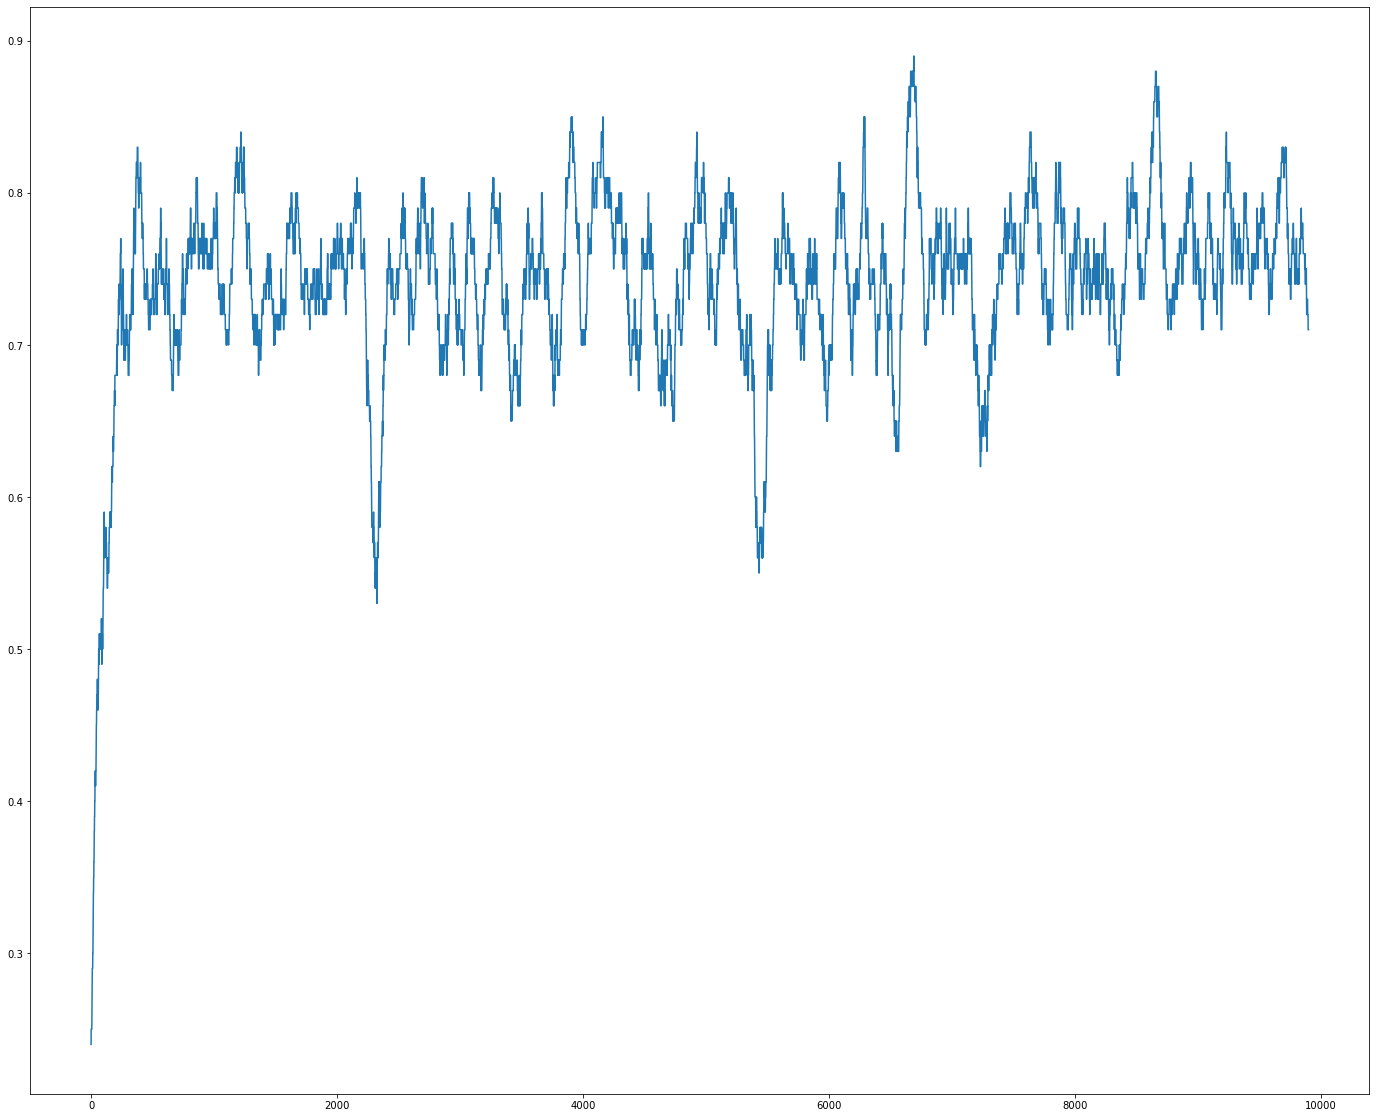

In [16]:
from matplotlib import pyplot as plt
from scipy.interpolate import pchip
import pandas as pd

def moving_average(a,n):
    N=len(a)
    return np.array([np.mean(a[i:i+n]) for i in np.arange(0,N-n+1)])

smooth = moving_average(ds, 100)
plt.plot(smooth)

In [32]:
"""
we compare the dynamic epsilon solution with the regular SARSA
It does show some improvement that 
"""
print("The average reward in Dynamic Epsilon SARSA agent is: \t",np.average(ds))
print("The average reward in SARSA agent epsilon = 0.01: \t",np.average(s1))
print("The average reward in SARSA agent epsilon = 0.05: \t",np.average(s2))
print("The average reward in SARSA agent epsilon = 0.1: \t",np.average(s3))
print("The average reward in SARSA agent epsilon = 0.3: \t",np.average(s4))
print("The average reward in Expected SARSA with no penaltyagent epsilon = 0.01: \t", np.average(no_penalty_results))

The average reward in Dynamic Epsilon SARSA agent is: 	 0.7376
The average reward in SARSA agent epsilon = 0.01: 	 0.6106
The average reward in SARSA agent epsilon = 0.05: 	 0.4495
The average reward in SARSA agent epsilon = 0.1: 	 0.3155
The average reward in SARSA agent epsilon = 0.3: 	 0.1178
The average reward in Expected SARSA with no penaltyagent epsilon = 0.01: 	 0.0144


In [10]:
from collections import defaultdict
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

class ESarsa():
    def __init__(self,
                env,gamma,epsilon,alpha):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.q = defaultdict(lambda : np.zeros(env.action_space.n))
    
    def choose_action(self, state):
        epsilon = self.epsilon
        if np.random.random() < epsilon:
            return env.action_space.sample()
        else:
            return np.argmax(self.q[state])
        
    def action_possibility(self, state):
        epsilon = self.epsilon
        P = []
        actions = self.q[state]
        n = env.action_space.n
        for i in range(0,n):
            if i == np.argmax(actions):
                P.append((epsilon/n) + 1 - epsilon)
            else:
                P.append(epsilon/n)
        return P
            
    def update_q(self, state, action, next_state, next_action, reward):
        P = self.action_possibility(next_state)        
        V = P * self.q[next_state]
        self.q[state][action] += self.alpha * (reward + self.gamma*sum(V) - self.q[state][action])
        
    
    def run_step(self, state, action):
        next_state, reward, done, _ = self.env.step(action)
        next_action = self.choose_action(next_state)
        
        
        "we modify the reward function to make the agent know that hole is not expected"
        if reward == 0 and done:
            reward = -0.5
        
        "make the epsilon dynamic, reduce exploration when reach the goal"
        if done and reward == 1:
            self.epsilon = max(0, self.epsilon - 0.01)
        self.update_q(state,action,next_state,next_action,reward)
        return next_state, next_action,reward,done
        
    def run_episode(self):
        epsilon = self.epsilon
        alpha = self.alpha
        episode_return = 0
        
        state = self.env.reset()
        action = self.choose_action(state)
        
        while True:
            state, action, reward,done = self.run_step(state,action)
            episode_return += reward
            if done:
                break
        return episode_return
    
    def learn_task(self, n):
        returns = []
        for i in tqdm(range(n)):
            episode_return = self.run_episode()
            returns.append(episode_return)
            if episode_return > 0:
                self.epsilon -= 0.01
        return returns

    

In [11]:
env = gym.make("FrozenLake-v1")
env.reset()  
agent = DSarsa(env, gamma = 0.9, epsilon = 0.1,
           alpha = 0.1)
es = agent.learn_task(10000)

100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1093.58it/s]

defaultdict(<function DSarsa.__init__.<locals>.<lambda> at 0x7fe217239040>, {0: array([ 0.03850815, -0.04714077, -0.06149468, -0.05834468]), 4: array([ 0.0544055 , -0.13249133, -0.15210896, -0.08981727]), 8: array([-0.07417566, -0.04144967, -0.12070512,  0.09841224]), 12: array([0., 0., 0., 0.]), 9: array([-0.07993422,  0.17713907, -0.17195   , -0.04041372]), 13: array([-0.05003649, -0.0905    ,  0.32150148, -0.00406475]), 10: array([ 0.27136622, -0.09508942, -0.095     , -0.06253585]), 5: array([0., 0., 0., 0.]), 1: array([-0.14689663, -0.08409167, -0.09103025,  0.01226048]), 14: array([0.00425801, 0.00100247, 0.69735081, 0.09872164]), 2: array([-0.09446971, -0.1085091 , -0.09542875,  0.00494644]), 6: array([-0.36295076, -0.35120781, -0.08713642, -0.357638  ]), 11: array([0., 0., 0., 0.]), 3: array([-0.12464601, -0.10107857, -0.12997873,  0.00116677]), 7: array([0., 0., 0., 0.]), 15: array([0., 0., 0., 0.])})


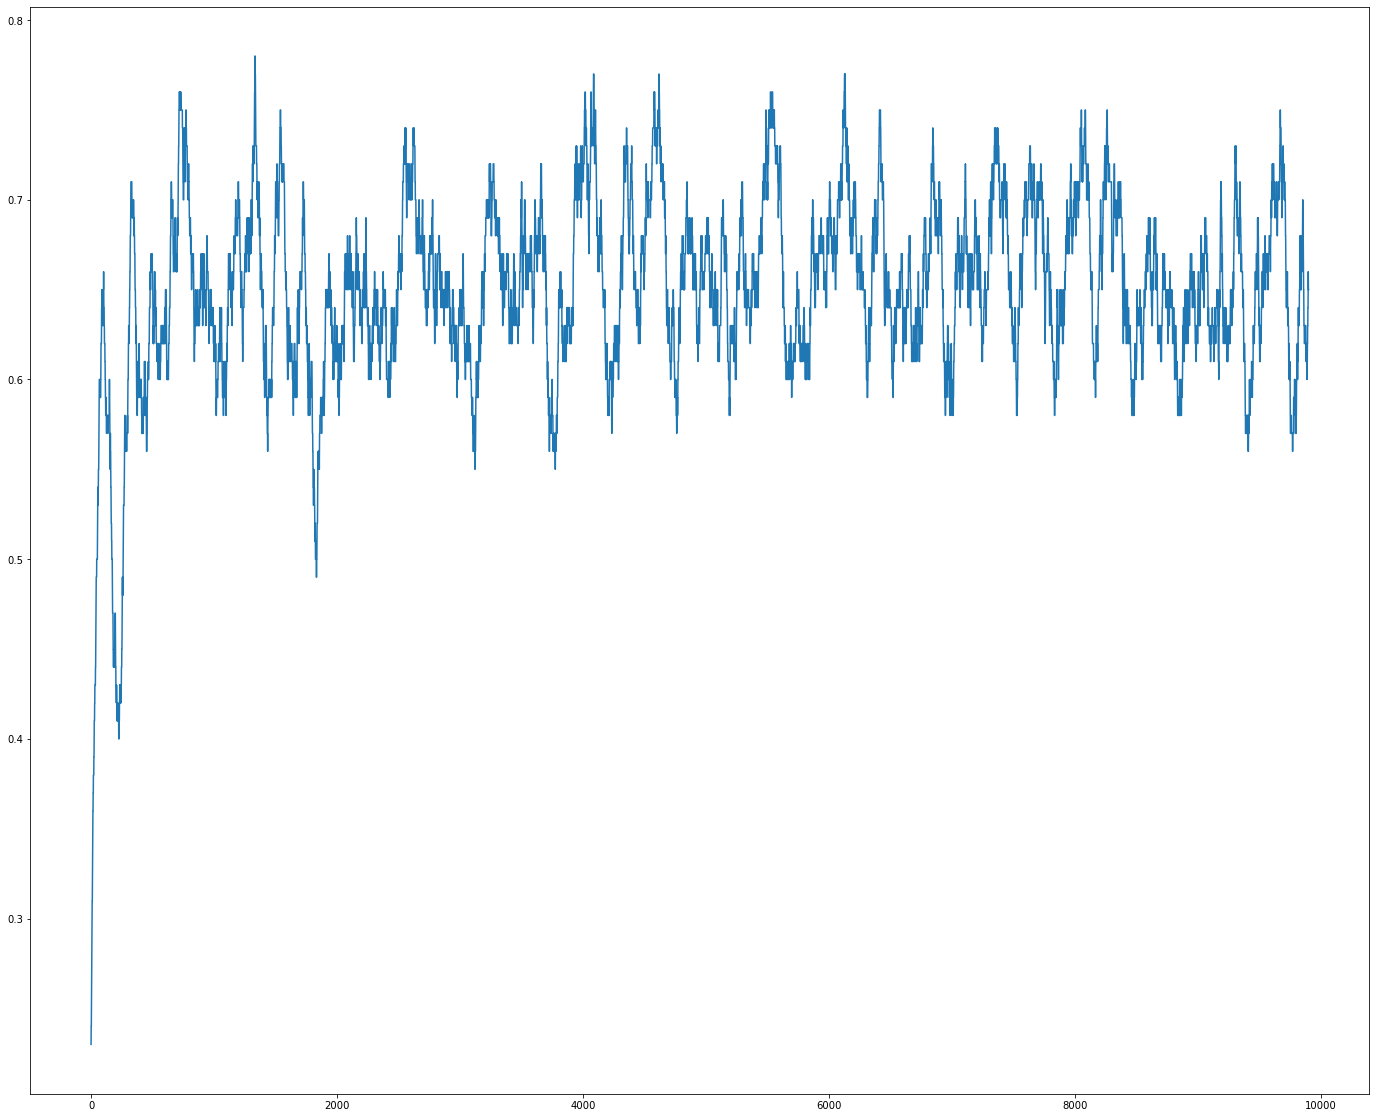

In [17]:
from matplotlib import pyplot as plt
from scipy.interpolate import pchip
import pandas as pd

def moving_average(a,n):
    N=len(a)
    return np.array([np.mean(a[i:i+n]) for i in np.arange(0,N-n+1)])

smooth = moving_average(es, 100)
plt.plot(smooth)

In [13]:
print("The average reward in expected SARSA agent is: \t\t",np.average(es))
print("The average reward in Dynamic Epsilon SARSA agent is: \t",np.average(ds))
print("The average reward in SARSA agent epsilon = 0.01: \t",np.average(s1))
print("The average reward in SARSA agent epsilon = 0.05: \t",np.average(s2))
print("The average reward in SARSA agent epsilon = 0.1: \t",np.average(s3))
print("The average reward in SARSA agent epsilon = 0.3: \t",np.average(s4))
print("The average reward in Expected SARSA with no penaltyagent epsilon = 0.01: \t", np.average(no_penalty_results))

The average reward in expected SARSA agent is: 		 0.6482
The average reward in Dynamic Epsilon SARSA agent is: 	 0.7376
The average reward in SARSA agent epsilon = 0.01: 	 0.6106
The average reward in SARSA agent epsilon = 0.05: 	 0.4495
The average reward in SARSA agent epsilon = 0.1: 	 0.3155
The average reward in SARSA agent epsilon = 0.3: 	 0.1178


In [33]:
es_smooth = moving_average(es,500)
ds_smooth = moving_average(ds,500)
s1_smooth = moving_average(s1,500)
s2_smooth = moving_average(s2,500)
s3_smooth = moving_average(s3,500)
s4_smooth = moving_average(s4,500)
no_penalty_smooth = moving_average(no_penalty_results, 500)

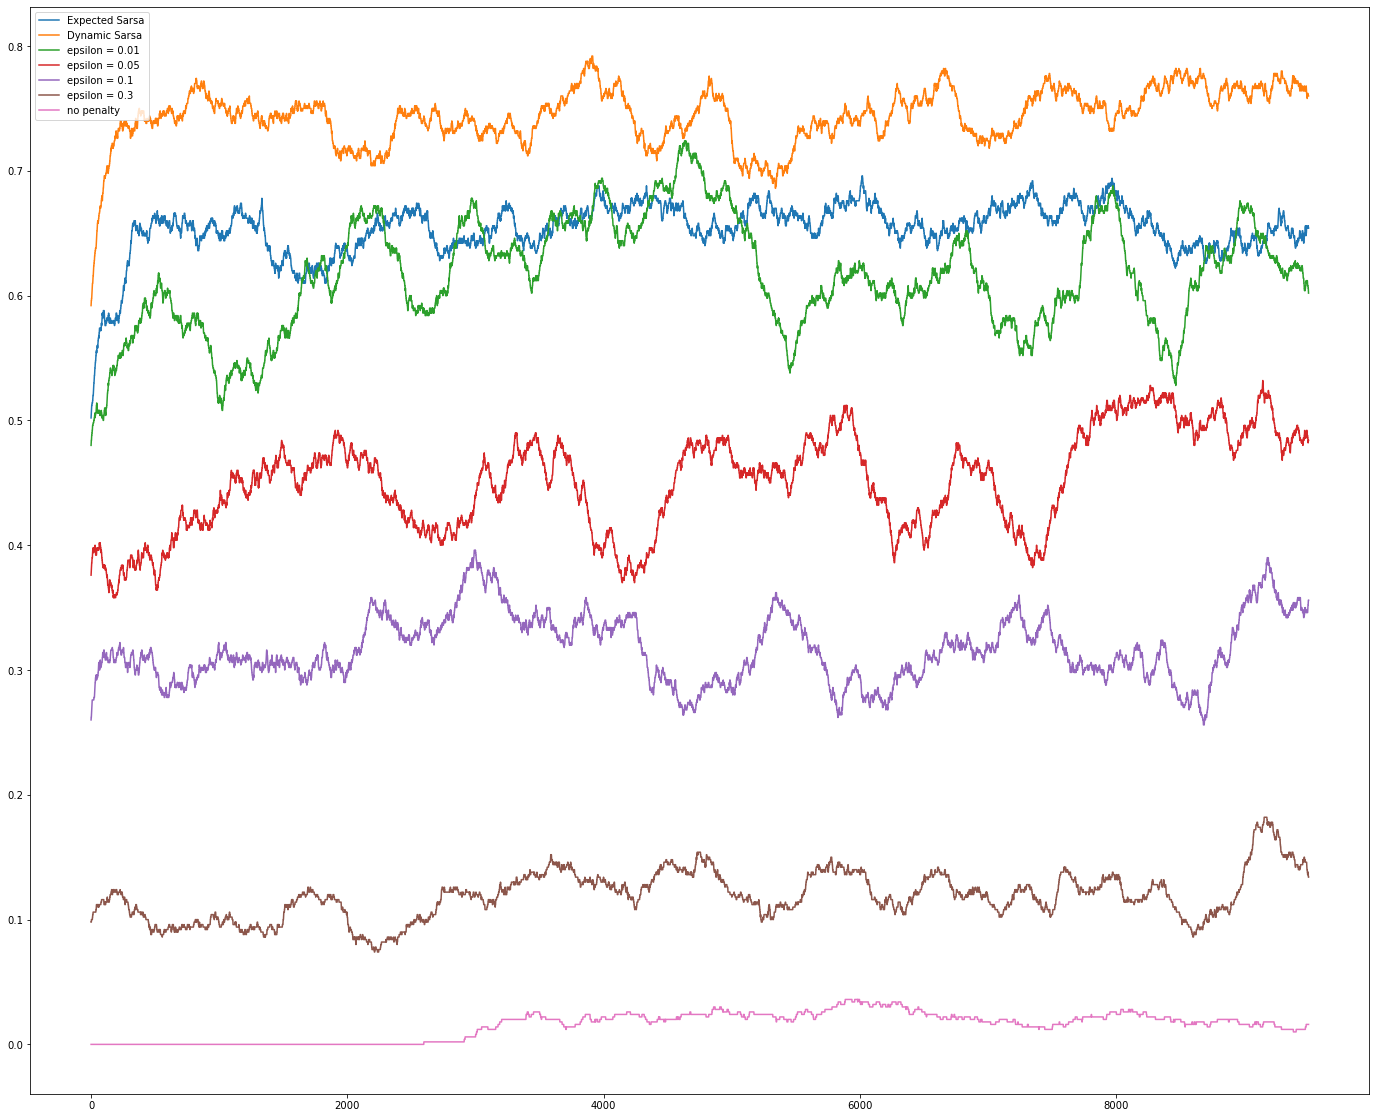

In [34]:
plt.plot(es_smooth,label="Expected Sarsa")
plt.plot(ds_smooth, label = "Dynamic Sarsa")
plt.plot(s1_smooth, label = "epsilon = 0.01")
plt.plot(s2_smooth, label = "epsilon = 0.05")
plt.plot(s3_smooth, label = "epsilon = 0.1")
plt.plot(s4_smooth, label = "epsilon = 0.3")
plt.plot(no_penalty_smooth, label = "no penalty")
plt.legend()
plt.rcParams["figure.figsize"] = [24,20]
plt.show()